In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For sklearn 0.18
# import sklearn.model_selection as skcv
import sklearn.cross_validation as skcv
import sklearn.ensemble as sk

## Вопросы
* Как работает roc_auc, где у классификатора переменный порог?
* ~~Как работает кросс-валидация, можно ли (нужно ли?) получить обученный классификатор?~~ По идее, учить сразу на всех тестовых данных лучше всего, кросс-валидировать можно и отдельно.

## Данные

### Gold.csv

Данный файл содержит снимки данных игры, содержащих количество золота для каждого игрока.

Каждая строчка файла содержит следующие колонки:

    mid — идентификатор матча
    times — время в секундах когда был сделан снимок
    player_0, player_1, player_2, player_3, player_4 — количество золота для игроков команды radiant
    player_5, player_6, player_7, player_8, player_9 — количество золота для игроков команды dire

In [11]:
gold = pd.read_csv('cont_01/gold.csv')
gold.head(20)

,mid,times,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9
0,0,60,750,350,389,437,428,398,344,654,287,1056
1,0,120,957,1071,633,655,1080,669,1147,1164,438,1360
2,0,180,1161,1527,782,1103,1346,1058,1479,1574,587,2072
3,0,240,1571,2033,932,1515,2058,1760,1767,2387,737,2283
4,0,300,1721,2313,1082,1790,2699,2087,1986,2898,887,3302
5,0,360,1871,2753,1232,2126,3645,2417,2382,3416,1037,4071
6,0,420,2022,3216,1382,2703,4176,2567,2778,4115,1187,4686
7,0,480,2850,3941,2129,3249,5040,2717,3326,4931,1424,5207
8,0,540,3303,4686,2402,3716,5546,3428,3596,5580,1574,5609
9,0,600,3454,5206,2613,4426,5755,4072,3997,5917,1725,6384


In [12]:

train = pd.read_csv('cont_01/train.csv')
train.head(10)

,mid,radiant_won
0,0,1
1,1,0
2,2,1
3,4,1
4,5,1
5,6,1
6,8,0
7,11,0
8,20,1
9,26,1


### lh.csv

Данный файл содержит снимки данных, содержащих количество убитых нейтральных монстров (крипов) для каждого игрока.
Каждая строчка файла содержит следующие колонки:

    mid — идентификатор матча
    times — время в секундах когда был сделан снимок
    player_0, player_1, player_2, player_3, player_4 — количество убитых монстров для игроков команды radiant
    player_5, player_6, player_7, player_8, player_9 — количество убитых монстров для игроков команды dire


In [13]:
lh = pd.read_csv('cont_01/lh.csv')
lh.head(10)

,mid,times,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9
0,0,60,1,2,1,1,2,3,2,7,1,2
1,0,120,1,5,1,2,6,5,6,14,1,6
2,0,180,2,10,1,7,8,9,9,18,1,9
3,0,240,2,13,1,13,12,9,12,29,1,10
4,0,300,2,15,1,17,19,13,13,36,1,19
5,0,360,2,20,1,20,24,16,17,42,1,31
6,0,420,3,26,1,28,30,16,21,52,1,31
7,0,480,4,36,1,36,35,16,28,63,2,36
8,0,540,4,37,2,43,40,25,30,72,2,38
9,0,600,4,43,3,57,41,34,35,75,2,46


In [14]:
events = pd.read_csv('cont_01/events.csv')
events.head(10)

,mid,event_type,from_team,time
0,0,3,radiant,1
1,1,3,radiant,222
2,2,3,dire,143
3,3,3,radiant,143
4,4,3,dire,53
5,6,3,radiant,82
6,6,6,radiant,523
7,7,3,dire,77
8,7,6,radiant,283
9,7,6,radiant,595


## Обработка

In [15]:
team0 = ['player_%s'%t for t in range(0,5)]
team1 = ['player_%s'%t for t in range(5,10)]
print(team0,team1)

['player_0', 'player_1', 'player_2', 'player_3', 'player_4'] ['player_5', 'player_6', 'player_7', 'player_8', 'player_9']


In [16]:
gold['gold_team0'] = gold[team0].sum(axis=1)
gold['gold_team1'] = gold[team1].sum(axis=1)
gold_end = gold[gold.times==600].drop('times',axis=1)
gold_end['ratio'] = gold_end.gold_team0 / gold.gold_team1

lh['lh_team0'] = lh[team0].sum(axis=1)
lh['lh_team1'] = lh[team1].sum(axis=1)
lh_end = lh[lh.times==600].drop('times',axis=1)
lh_end['lh_ratio'] = lh_end.lh_team0 / lh.lh_team1
lh_end.head()

,mid,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9,lh_team0,lh_team1,lh_ratio
9,0,4,43,3,57,41,34,35,75,2,46,148,192,0.770833
19,1,5,63,14,28,47,49,23,3,30,39,157,144,1.090278
29,2,34,6,69,42,23,6,12,56,13,12,174,99,1.757576
39,3,1,49,48,3,31,28,51,6,50,8,132,143,0.923077
49,4,30,41,45,23,4,26,9,23,37,6,143,101,1.415842


In [17]:
%matplotlib inline

/nix/store/1kwbkwzxgm5z7m9ylr14qzqnri4nz3ih-python3.5-matplotlib-1.5.1/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/nix/store/1kwbkwzxgm5z7m9ylr14qzqnri4nz3ih-python3.5-matplotlib-1.5.1/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


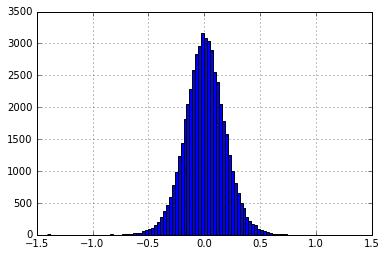

In [18]:
# gold_end.ratio.hist(bins=100)
# Use log to balance cases like (0.3 vs 3)
np.log(gold_end['ratio']).hist(bins=100)

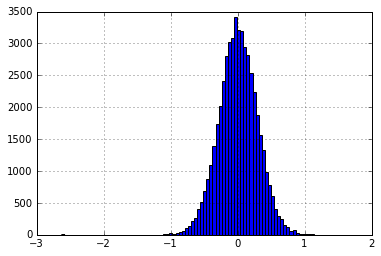

In [19]:
np.log(lh_end['lh_ratio']).hist(bins=100)

In [20]:
def get_meshgrid(X, f1, f2, npoints=100, border=1):
    step1 = (X[f1].max() - X[f1].min()) / npoints
    step2 = (X[f2].max() - X[f2].min()) / npoints
    x1_min, x1_max = X[f1].min() - border, X[f1].max() + border
    x2_min, x2_max = X[f2].min() - border, X[f2].max() + border
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, step1), np.arange(x2_min, x2_max, step2))
    return xx1,xx2

def vis_mesh(clf, X, Y, f1,f2, draw_points=True):
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    xx1,xx2 = get_meshgrid(X, f1,f2)
    xgr = np.c_[xx1.ravel(), xx2.ravel()]
    y = clf.predict(xgr).reshape(xx1.shape)
    plt.pcolormesh(xx1,xx2,y, cmap=plt.cm.RdYlBu)
    if draw_points :
        c = ['r' if y==0 else 'b' for y in Y]
        Xrnd = X.sample(frac=1)
        plt.scatter(Xrnd[f1].iloc[:], Xrnd[f2].iloc[:], c=c, cmap=plt.cm.RdYlBu)

## Обучение на двух параметрах (по gold)

Эксперименты с глубиной дерева

In [21]:
data = pd.merge(train,gold_end,on='mid',how='left')
X = data.drop(['mid', 'radiant_won'], axis=1).drop(team0 + team1 + ["gold_team1"], axis=1)
Y = data['radiant_won']
print('gold_end', len(gold_end.index))
print(gold_end.head())
print('X', len(X.index))
print(X.head())

gold_end 49948
    mid  player_0  player_1  player_2  player_3  player_4  player_5  player_6  \
9     0      3454      5206      2613      4426      5755      4072      3997   
19    1      2477      5760      3816      4353      5759      7659      5066   
29    2      3604      1948      8581      4390      2869      3096      2301   
39    3      3457      5464      4432      2961      4314      3345      4791   
49    4      3675      4103      5154      3030      2076      3920      3494   

    player_7  player_8  player_9  gold_team0  gold_team1     ratio  
9       5917      1725      6384       21454       22095  0.970989  
19      2748      4440      4623       22165       24536  0.903366  
29      5130      2530      2491       21392       15548  1.375868  
39      1906      5328      2247       20628       17617  1.170914  
49      3392      4458      2220       18038       17484  1.031686  
X 24974
   gold_team0     ratio
0       21454  0.970989
1       22165  0.903366
2   

In [22]:
clf = sk.RandomForestClassifier(n_estimators=100, max_depth=2)
clf.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

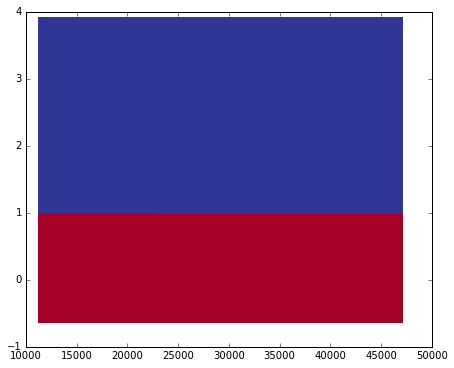

In [23]:
vis_mesh(clf, X, Y, "gold_team0", "ratio", draw_points=False)

In [24]:
cvs = skcv.cross_val_score(clf, X, Y, cv=5, scoring='roc_auc')
print('mean=',cvs.mean(),'std=', cvs.std())

mean= 0.695626838218 std= 0.00299818463896


Зависимость скоринга от глубины дерева. Поставлено маленькое количество эстиматоров, для увеличения скорости. На полных эстиматорах получается, что оптимальная глубина дерева равна шести.

depth =  1 mean = 0.66297533962 std = 0.00518862435408
depth =  2 mean = 0.688402113227 std = 0.0150877011242
depth =  3 mean = 0.699291735981 std = 0.00330680625071
depth =  4 mean = 0.69965087287 std = 0.00434997356011
depth =  5 mean = 0.701492587577 std = 0.00355154992343
depth =  6 mean = 0.701026913753 std = 0.00513990382329
depth =  7 mean = 0.700156719523 std = 0.00518628134199
depth =  8 mean = 0.695889904529 std = 0.00363829671604
depth =  9 mean = 0.691792004559 std = 0.00523980792576
depth =  10 mean = 0.688728994941 std = 0.0043320603821


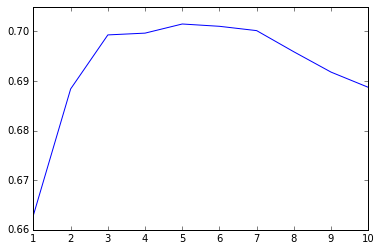

In [25]:
scores=[]
depths = [1,2,3,4,5,6,7,8,9,10]
for d in depths:
    clf = sk.RandomForestClassifier(n_estimators=5, max_depth=d)
    clf.fit(X, Y)
    cvs = skcv.cross_val_score(clf, X, Y, cv=5, scoring='roc_auc')
    print('depth = ', d, 'mean =',cvs.mean(),'std =', cvs.std())
    scores.append(cvs.mean())

plt.plot(depths, scores)

## Обучение на gold.ratio и lh.ratio


In [26]:
data_1 = pd.merge(train,gold_end.drop(team0+team1,axis=1),on='mid',how='left')
data_2 = pd.merge(train,lh_end.drop(team0+team1,axis=1),on='mid',how='left')
data = pd.merge(data_1, data_2, on=['mid','radiant_won'], how='inner')
X = data.drop(['gold_team1', 'gold_team0', 'lh_team1', 'lh_team0', 'mid', 'radiant_won'], axis=1)
Y = data['radiant_won']
print(len(gold_end.index), len(lh_end.index), len(data.index))


49948 49948 24974


In [27]:
data_1 = pd.merge(gold_end.drop(team0+team1,axis=1),
                  lh_end.drop(team0+team1,axis=1),
                  on='mid',how='inner')
data = pd.merge(train, data_1,on=['mid'], how='inner')
X = data.drop(['gold_team1', 'gold_team0', 'lh_team1', 'lh_team0', 'mid', 'radiant_won'], axis=1)
Y = data['radiant_won']
print(len(gold_end.index), len(lh_end.index), len(data_1.index), len(data.index))
print(X.head())

49948 49948 49948 24974
      ratio  lh_ratio
0  0.970989  0.770833
1  0.903366  1.090278
2  1.375868  1.757576
3  1.031686  1.415842
4  0.726691  0.662069


Так же, для ускорения анализ делается на малом количестве эстиматоров

depth = 1 mean = 0.655707192262 std = 0.00669031376608
depth = 2 mean = 0.68974598254 std = 0.00581156479579
depth = 3 mean = 0.697601700054 std = 0.00552291373185
depth = 4 mean = 0.699619461386 std = 0.00572711343932
depth = 5 mean = 0.701612377298 std = 0.00410418896059
depth = 6 mean = 0.700322825456 std = 0.00518891029368
depth = 7 mean = 0.699623107992 std = 0.00468446671358
depth = 8 mean = 0.696919563705 std = 0.0052100215184
depth = 9 mean = 0.691947045198 std = 0.00511283506164
depth = 10 mean = 0.689127232463 std = 0.00451080348941


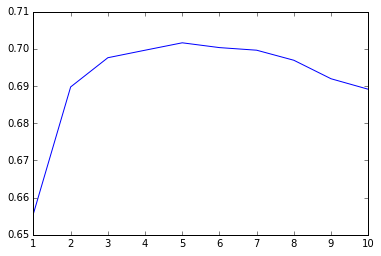

In [28]:
scores=[]
depths = [1,2,3,4,5,6,7,8,9,10]
for d in depths:
    clf = sk.RandomForestClassifier(n_estimators=6, max_depth=d)
    clf.fit(X, Y)
    cvs = skcv.cross_val_score(clf, X, Y, cv=5, scoring='roc_auc')
    print('depth =', d, 'mean =',cvs.mean(),'std =', cvs.std())
    scores.append(cvs.mean())

plt.plot(depths, scores)

mean = 0.702653253147 std = 0.00501822164139


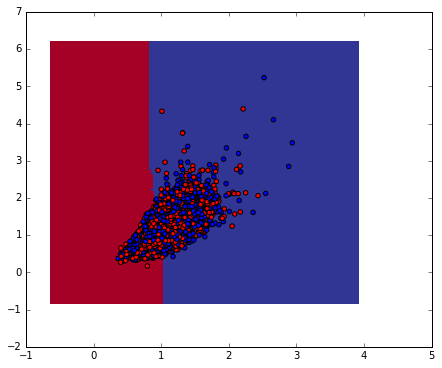

In [29]:
clf = sk.RandomForestClassifier(n_estimators=10, max_depth=5)
clf.fit(X, Y)
vis_mesh(clf, X, Y, "ratio", "lh_ratio", draw_points=True)
cvs = skcv.cross_val_score(clf, X, Y, cv=5, scoring='roc_auc')
print('mean =',cvs.mean(),'std =', cvs.std())

## Обучение на всех данных gold

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


In [ ]:
data = pd.merge(train,gold_end,on='mid',how='left')
X = data.drop(['mid', 'radiant_won'], axis=1) #.drop(team0, axis=1).drop(team1, axis=1)
Y = data['radiant_won']

clf = sk.RandomForestClassifier(n_estimators=100)
clf.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
skcv.cross_val_score(clf, X, Y, cv=5, scoring='roc_auc')

In [ ]:
clf.predict(X.iloc[:])

http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html

In [ ]:
def draw_contour(clf, X, feature1, feature2):
    #plot_step = 100
    #x1_min, x1_max = X[feature1].min() - 1, X[feature1].max() + 1
    #x2_min, x2_max = X[feature2].min() - 1, X[feature2].max() + 1
    #xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, plot_step),
    #                       np.arange(x2_min, x2_max, plot_step))
    y = clf.predict(X)
    idx0 = np.where(y==0)
    idx1 = np.where(y==1)
    #print(f1.iloc[idx0].values)
    plt.scatter(X[feature1].iloc[idx0], X[feature2].iloc[idx0], c='r', cmap=plt.cm.RdYlBu)
    plt.scatter(X[feature1].iloc[idx1], X[feature2].iloc[idx1], c='b', cmap=plt.cm.RdYlBu)
    
draw_contour(clf, X, "ratio", "ratio")
plt.show()
    